<a href="https://colab.research.google.com/github/asmit-ayank/UML501/blob/main/Assignment_AdaBoost_UML501.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment AdaBoost - Asmit Ayank (102497002)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


In [ ]:
import pandas as pd, numpy as np, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Load dataset
df = pd.read_csv("/root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1/spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']

# 2. Label encoding
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# 3. Preprocessing
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join([w for w in text.split() if w not in stop_words])

df['text'] = df['text'].apply(clean_text)

# 4. TF-IDF
X = TfidfVectorizer().fit_transform(df['text'])
y = df['label']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Class distribution
print("Class distribution:\n", df['label'].value_counts())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Class distribution:
 label
0    4825
1     747
Name: count, dtype: int64


In [ ]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("Train Acc:", accuracy_score(y_train, stump.predict(X_train))*100)
print("Test Acc:", accuracy_score(y_test, stump.predict(X_test))*100)
print("Confusion Matrix:\n", confusion_matrix(y_test, stump.predict(X_test)))

Train Acc: 88.42270585595692
Test Acc: 89.05829596412556
Confusion Matrix:
 [[923  42]
 [ 80  70]]


In [ ]:
T = 15
n = X_train.shape[0]
weights = np.ones(n) / n
alphas, errors = [], []

for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(X_train, y_train, sample_weight=weights)
    pred = clf.predict(X_train)
    err = np.sum(weights * (pred != y_train)) / np.sum(weights)
    alpha = 0.5 * np.log((1 - err) / (err + 1e-10))

    # Update weights
    weights *= np.exp(-alpha * y_train * (2 * pred - 1))
    weights /= np.sum(weights)

    alphas.append(alpha)
    errors.append(err)

    print(f"Round {t+1}: Error={err:.4f}, Alpha={alpha:.4f}")
    print("Misclassified indices:", np.where(pred != y_train)[0])
    print("Weights of misclassified:", weights[pred != y_train])

Round 1: Error=0.1158, Alpha=1.0165
Misclassified indices: [   1    6   17   33   34   51   58   71   73   80   96  101  103  107
  108  120  122  132  147  148  154  187  190  200  208  212  214  216
  222  245  249  259  271  278  292  300  303  304  311  316  334  337
  342  370  388  391  392  407  412  421  457  468  469  485  486  489
  492  502  512  519  522  531  534  544  551  557  560  588  603  610
  611  623  626  627  629  630  631  642  643  646  652  659  664  672
  673  681  703  712  714  715  723  729  775  776  780  805  809  822
  847  863  871  881  886  887  893  910  925  946  965  968  978  995
  997 1002 1014 1019 1073 1082 1084 1091 1092 1144 1170 1187 1204 1208
 1228 1232 1236 1237 1239 1245 1246 1250 1267 1285 1299 1303 1306 1313
 1314 1315 1322 1328 1330 1343 1354 1356 1361 1369 1386 1407 1414 1419
 1422 1435 1440 1449 1450 1456 1457 1460 1467 1470 1471 1480 1486 1489
 1496 1505 1510 1527 1530 1534 1540 1546 1559 1573 1574 1588 1592 1596
 1598 1609 1612 16

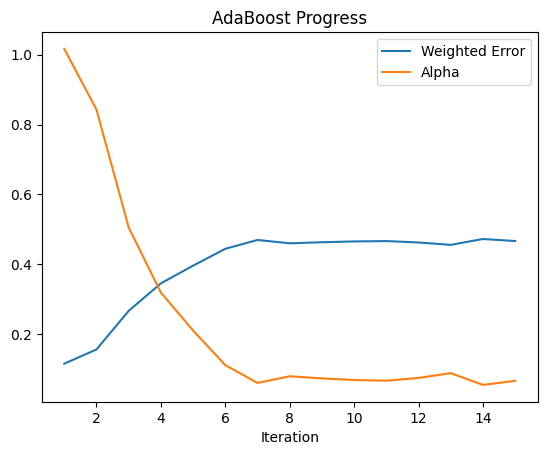

In [ ]:
plt.plot(range(1, T+1), errors, label='Weighted Error')
plt.plot(range(1, T+1), alphas, label='Alpha')
plt.xlabel("Iteration"); plt.legend(); plt.title("AdaBoost Progress"); plt.show()

In [ ]:
# Combine weak learners
from scipy.sparse import vstack
train_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(X_test.shape[0])

weights = np.ones(X_train.shape[0]) / X_train.shape[0]
models = []

for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(X_train, y_train, sample_weight=weights)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    err = np.sum(weights * (pred_train != y_train)) / np.sum(weights)
    alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
    weights *= np.exp(-alpha * y_train * (2 * pred_train - 1))
    weights /= np.sum(weights)
    train_preds += alpha * (2 * pred_train - 1)
    test_preds += alpha * (2 * pred_test - 1)

final_train = (train_preds > 0).astype(int)
final_test = (test_preds > 0).astype(int)

print("Manual AdaBoost Train Acc:", accuracy_score(y_train, final_train)*100)
print("Manual AdaBoost Test Acc:", accuracy_score(y_test, final_test)*100)
print("Confusion Matrix:\n", confusion_matrix(y_test, final_test))

Manual AdaBoost Train Acc: 87.83935382544313
Manual AdaBoost Test Acc: 88.07174887892377
Confusion Matrix:
 [[963   2]
 [131  19]]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
ada.fit(X_train, y_train)
print("Sklearn AdaBoost Train Acc:", accuracy_score(y_train, ada.predict(X_train))*100)
print("Sklearn AdaBoost Test Acc:", accuracy_score(y_test, ada.predict(X_test))*100)
print("Confusion Matrix:\n", confusion_matrix(y_test, ada.predict(X_test)))

Sklearn AdaBoost Train Acc: 91.72088849001571
Sklearn AdaBoost Test Acc: 92.46636771300449
Confusion Matrix:
 [[963   2]
 [ 82  68]]


##Q2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

In [ ]:
heart_data = fetch_openml(data_id=1565, as_frame=True, parser='auto')
X = heart_data.data
y = heart_data.target

X = X.fillna(X.median())
y = (pd.to_numeric(y, errors='coerce') > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
print("=== PART A: DECISION STUMP ===")
print(f"Train Acc: {stump.score(X_train, y_train):.4f}")
print(f"Test Acc: {stump.score(X_test, y_test):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, stump.predict(X_test)))
print(classification_report(y_test, stump.predict(X_test)))

=== PART A: DECISION STUMP ===
Train Acc: 1.0000
Test Acc: 1.0000
Confusion Matrix:
 [[89]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        89

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



#Part B


=== PART B: ADABOOST TUNING ===


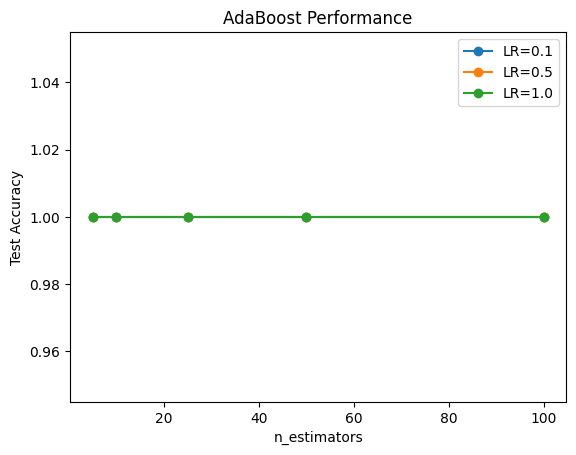

Best: n_estimators=5, lr=0.1, acc=1.0000


In [ ]:
print("\n=== PART B: ADABOOST TUNING ===")
n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]
results = []

for lr in learning_rates:
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=n_est, learning_rate=lr, random_state=42, algorithm='SAMME')
        ada.fit(X_train, y_train)
        results.append({'n_estimators': n_est, 'learning_rate': lr, 'test_acc': ada.score(X_test, y_test)})

results_df = pd.DataFrame(results)
for lr in learning_rates:
    subset = results_df[results_df['learning_rate'] == lr]
    plt.plot(subset['n_estimators'], subset['test_acc'], marker='o', label=f'LR={lr}')
plt.xlabel('n_estimators')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title('AdaBoost Performance')
plt.show()

best = results_df.loc[results_df['test_acc'].idxmax()]
print(f"Best: n_estimators={int(best['n_estimators'])}, lr={best['learning_rate']}, acc={best['test_acc']:.4f}")


=== PART C: MISCLASSIFICATION PATTERN ===


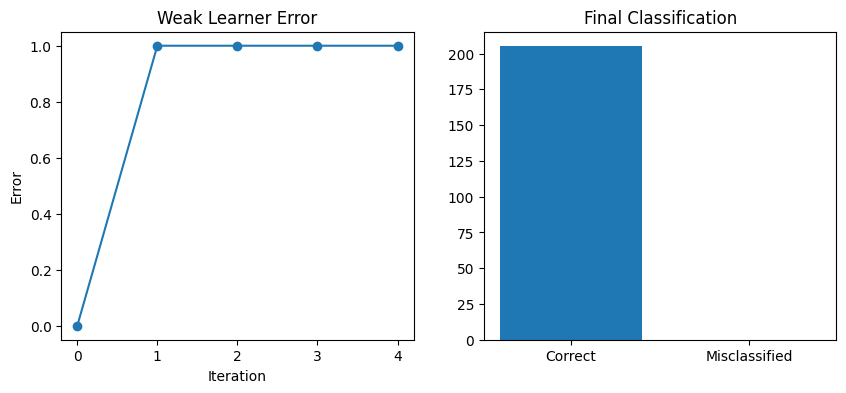


=== PART D: FEATURE IMPORTANCE ===
  Feature  Importance
0      V1         0.0
1      V2         0.0
2      V3         0.0
3      V4         0.0
4      V5         0.0


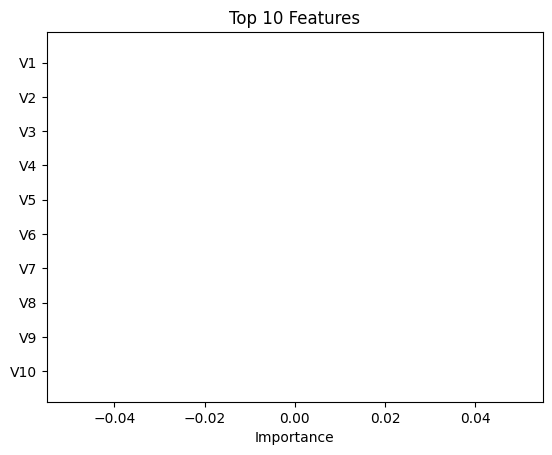

In [ ]:
print("\n=== PART C: MISCLASSIFICATION PATTERN ===")
best_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                               n_estimators=int(best['n_estimators']),
                               learning_rate=best['learning_rate'], random_state=42, algorithm='SAMME')
best_ada.fit(X_train, y_train)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(best_ada.estimator_errors_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Weak Learner Error')

plt.subplot(1, 2, 2)
errors = (best_ada.predict(X_train) != y_train).astype(int)
plt.bar(['Correct', 'Misclassified'], [np.sum(errors == 0), np.sum(errors == 1)])
plt.title('Final Classification')
plt.show()

# PART D: Feature Importance
print("\n=== PART D: FEATURE IMPORTANCE ===")
importance_df = pd.DataFrame({'Feature': heart_data.data.columns,
                              'Importance': best_ada.feature_importances_}).sort_values('Importance', ascending=False)
print(importance_df.head(5))

plt.barh(importance_df.head(10)['Feature'], importance_df.head(10)['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Features')
plt.gca().invert_yaxis()
plt.show()


Next Ques

In [ ]:
import kagglehub
import os
path = kagglehub.dataset_download("adamlouly/wisdmdata")
print("Path to dataset files:", path)

# Read the raw accelerometer data
file_path = os.path.join(path, 'WISDM_ar_v1.1_raw.txt')
columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
wisdm_data = pd.read_csv(file_path, header=None, names=columns, on_bad_lines='skip')

# Clean data - remove semicolons and convert to numeric
wisdm_data['z'] = wisdm_data['z'].astype(str).str.replace(';', '')
wisdm_data[['x', 'y', 'z']] = wisdm_data[['x', 'y', 'z']].apply(pd.to_numeric, errors='coerce')
wisdm_data = wisdm_data.dropna()

# Create binary labels: 1 = vigorous (Jogging, Upstairs), 0 = light (Walking, Sitting, Standing, Downstairs)
vigorous_activities = ['Jogging', 'Upstairs']
wisdm_data['label'] = wisdm_data['activity'].apply(lambda x: 1 if x in vigorous_activities else 0)

100%|██████████| 10.7M/10.7M [00:00<00:00, 63.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adamlouly/wisdmdata/versions/1


In [ ]:
X_activity = wisdm_data[['x', 'y', 'z']].values
y_activity = wisdm_data['label'].values

print(f"Dataset shape: {X_activity.shape}")
print(f"Activity distribution:\n{pd.Series(y_activity).value_counts()}")

X_train_act, X_test_act, y_train_act, y_test_act = train_test_split(
    X_activity, y_activity, test_size=0.3, random_state=42, stratify=y_activity)

Dataset shape: (1086465, 3)
Activity distribution:
0    627151
1    459314
Name: count, dtype: int64


In [ ]:
print("\n=== ACTIVITY - PART B: WEAK CLASSIFIER ===")
stump_act = DecisionTreeClassifier(max_depth=1, random_state=42)
stump_act.fit(X_train_act, y_train_act)
print(f"Train Acc: {stump_act.score(X_train_act, y_train_act):.4f}")
print(f"Test Acc: {stump_act.score(X_test_act, y_test_act):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_act, stump_act.predict(X_test_act)))


=== ACTIVITY - PART B: WEAK CLASSIFIER ===
Train Acc: 0.6521
Test Acc: 0.6519
Confusion Matrix:
 [[170673  17473]
 [ 95986  41808]]



=== ACTIVITY - PART C: MANUAL ADABOOST ===
Iter 1: Error=0.3479, Alpha=0.3142, Misclassified=264567
  Indices: [0, 2, 3, 5, 6], Weights: [1.88988045e-06 1.88988045e-06 1.88988045e-06 1.88988045e-06
 1.88988045e-06]
Iter 2: Error=0.4649, Alpha=0.0703, Misclassified=288779
  Indices: [0, 1, 2, 5, 6], Weights: [2.03256081e-06 1.08426221e-06 2.03256081e-06 2.03256081e-06
 2.03256081e-06]
Iter 3: Error=0.4489, Alpha=0.1026, Misclassified=439005
  Indices: [4, 7, 9, 11, 14], Weights: [1.04933553e-06 1.96708717e-06 1.04933553e-06 1.04933553e-06
 1.04933553e-06]
Iter 4: Error=0.4489, Alpha=0.1026, Misclassified=300395
  Indices: [0, 1, 2, 3, 5], Weights: [2.05409281e-06 1.09574837e-06 2.05409281e-06 1.78462502e-06
 2.05409281e-06]
Iter 5: Error=0.4576, Alpha=0.0851, Misclassified=439005
  Indices: [4, 7, 9, 11, 14], Weights: [1.04024147e-06 1.95003942e-06 1.04024147e-06 1.04024147e-06
 1.04024147e-06]
Iter 6: Error=0.4607, Alpha=0.0788, Misclassified=291148
  Indices: [0, 1, 2, 5, 6], Weights

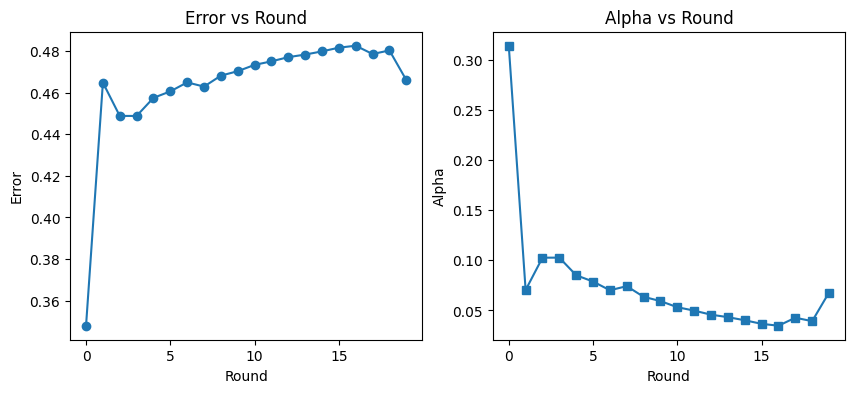

In [ ]:
print("\n=== ACTIVITY - PART C: MANUAL ADABOOST ===")
class ManualAdaBoost:
    def __init__(self, T=20):
        self.T = T
        self.clfs = []
        self.alphas = []
        self.errors = []

    def fit(self, X, y):
        n = X.shape[0]
        w = np.ones(n) / n
        y_coded = 2 * y - 1

        for t in range(self.T):
            clf = DecisionTreeClassifier(max_depth=1, random_state=t)
            clf.fit(X, y, sample_weight=w)
            y_pred = clf.predict(X)
            y_pred_coded = 2 * y_pred - 1

            incorrect = (y_pred != y)
            error = np.sum(w * incorrect) / np.sum(w)
            error = np.clip(error, 1e-10, 1 - 1e-10)
            alpha = 0.5 * np.log((1 - error) / error)

            w = w * np.exp(-alpha * y_coded * y_pred_coded)
            w = w / np.sum(w)

            self.clfs.append(clf)
            self.alphas.append(alpha)
            self.errors.append(error)

            print(f"Iter {t+1}: Error={error:.4f}, Alpha={alpha:.4f}, Misclassified={np.sum(incorrect)}")
            print(f"  Indices: {np.where(incorrect)[0][:5].tolist()}, Weights: {w[incorrect][:5]}")

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for alpha, clf in zip(self.alphas, self.clfs):
            pred += alpha * (2 * clf.predict(X) - 1)
        return (np.sign(pred) + 1) / 2

manual_ada = ManualAdaBoost(T=20)
manual_ada.fit(X_train_act, y_train_act)

y_train_pred = manual_ada.predict(X_train_act)
y_test_pred = manual_ada.predict(X_test_act)
print(f"\nManual AdaBoost - Train Acc: {accuracy_score(y_train_act, y_train_pred):.4f}")
print(f"Manual AdaBoost - Test Acc: {accuracy_score(y_test_act, y_test_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_act, y_test_pred))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(manual_ada.errors, marker='o')
plt.xlabel('Round')
plt.ylabel('Error')
plt.title('Error vs Round')

plt.subplot(1, 2, 2)
plt.plot(manual_ada.alphas, marker='s')
plt.xlabel('Round')
plt.ylabel('Alpha')
plt.title('Alpha vs Round')
plt.show()

In [ ]:
print("\n=== ACTIVITY - PART D: SKLEARN ADABOOST ===")
sklearn_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=100, learning_rate=1.0, random_state=42, algorithm='SAMME')
sklearn_ada.fit(X_train_act, y_train_act)
print(f"Sklearn - Train Acc: {sklearn_ada.score(X_train_act, y_train_act):.4f}")
print(f"Sklearn - Test Acc: {sklearn_ada.score(X_test_act, y_test_act):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_act, sklearn_ada.predict(X_test_act)))
print(classification_report(y_test_act, sklearn_ada.predict(X_test_act)))

print("\n=== COMPARISON ===")
print(f"Manual (T=20): Test Acc = {accuracy_score(y_test_act, y_test_pred):.4f}")
print(f"Sklearn (T=100): Test Acc = {sklearn_ada.score(X_test_act, y_test_act):.4f}")


=== ACTIVITY - PART D: SKLEARN ADABOOST ===
Sklearn - Train Acc: 0.6976
Sklearn - Test Acc: 0.6969
Confusion Matrix:
 [[164210  23936]
 [ 74851  62943]]
              precision    recall  f1-score   support

           0       0.69      0.87      0.77    188146
           1       0.72      0.46      0.56    137794

    accuracy                           0.70    325940
   macro avg       0.71      0.66      0.66    325940
weighted avg       0.70      0.70      0.68    325940


=== COMPARISON ===
Manual (T=20): Test Acc = 0.6954
Sklearn (T=100): Test Acc = 0.6969
